### Evaluation and descriptive statistics
---------------------
Kilian Lüders & Bent Stohlmann

8.6.2023 (Submitted Version)

This notebook contains all of the analysis, descriptive statistics, tables, and plots that can be found in the paper.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# metadata of GFCC decisions
metadata = pd.read_csv("data/Metadaten2.6.1.csv", sep="\t")
metadata = metadata.rename(columns={'dateiname': 'entscheidung'}) # uniform variable naming

# training data decision level
data_dec = pd.read_pickle("data/training_data.pkl")

### Description data set

In [3]:
# number of all decisions in the decision collection
metadata.shape[0]

10663

In [4]:
# selection of decisions that are in the target population.
metadata = metadata[metadata['jahr'] < 2021] # before 2021
metadata = metadata[metadata['inAS'] == 1] # in the official collection
metadata = metadata[metadata['gruende'] == 1] # has a justification
metadata = metadata[metadata['spruchkoerper'].isin(['I','II'])] # from one of the senates 

In [5]:
# number of decisions in the target population 
metadata.entscheidung.nunique()

3371

In [6]:
# number of annotated decisions
data_dec.entscheidung.nunique()

300

In [7]:
# equivalence of book pages in the official collection
metadata.merge(data_dec, on='entscheidung', how='right').apply(lambda row: row.letzteSeite - row.ersteSeite + 1, axis=1).sum().astype(int)

5739

### Description of the annotation

In [8]:
# Number of decisions with proportionality test
(data_dec.prop > 0).value_counts()

False    240
True      60
Name: prop, dtype: int64

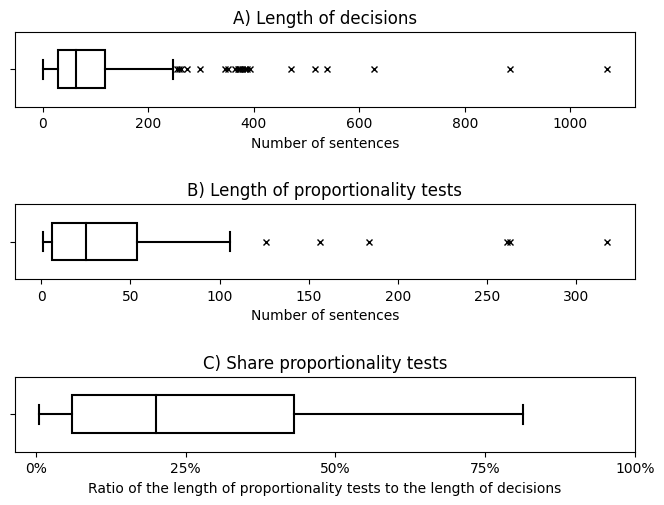

In [9]:
PROPS = {
    'boxprops':{'facecolor':'none', 'edgecolor':'black'},
    'medianprops':{'color':'black'},
    'whiskerprops':{'color':'black'},
    'capprops':{'color':'black'},
    'flierprops': {'marker':'x','markeredgecolor':'black'}
}

plt_df = data_dec[data_dec.prop > 0].copy()
plt_df['share'] = plt_df.apply(lambda row: row.prop / row.len, axis=1)

fig, axs = plt.subplots(nrows=3,figsize=(8, 7))

#fig.tight_layout(pad=5.0)
sns.boxplot(x = data_dec['len'], color='white', width=.5, **PROPS, ax=axs[0])
axs[0].set_title("A) Length of decisions")
axs[0].set_xlabel("Number of sentences")
sns.boxplot(x = plt_df['prop'], color='white', width=.5, **PROPS, ax=axs[1])
axs[1].set_title("B) Length of proportionality tests")
axs[1].set_xlabel("Number of sentences")
sns.boxplot(x = plt_df['share'], color='white', width=.5, **PROPS, ax=axs[2])
axs[2].set_title("C) Share proportionality tests")
axs[2].set_xlabel("Ratio of the length of proportionality tests to the length of decisions")
axs[2].set_xticks([0,0.25,0.5,0.75,1],['0%','25%','50%','75%','100%'])

fig.subplots_adjust(bottom=0.2,
                    top=0.8,
                    hspace=1.3)
plt.show()

## Performance Tabels

### Dec Level Classification

In [10]:
metrics_dec = pd.read_csv("data/20230607_performance_data.csv", index_col=0).rename(columns={'info':'text'})
metrics_dec['feature'] = metrics_dec['feature'].fillna("")
metrics_dec['text'] = metrics_dec['text'].fillna("")
metrics_dec.head()

,model,feature,text,type,fold,tn,fp,fn,tp,precision_ind_0,precision_ind_1,precision_micro,recall_ind_0,recall_ind_1,recall_micro,fscore_ind_0,fscore_ind_1,fscore_mirco,loss
0,majority,,,dec,0,48,0,12,0,0.8,0.0,0.8,1.0,0.0,0.8,0.888889,0.0,0.8,NaN
1,majority,,,dec,1,48,0,12,0,0.8,0.0,0.8,1.0,0.0,0.8,0.888889,0.0,0.8,NaN
2,majority,,,dec,2,48,0,12,0,0.8,0.0,0.8,1.0,0.0,0.8,0.888889,0.0,0.8,NaN
3,majority,,,dec,3,48,0,12,0,0.8,0.0,0.8,1.0,0.0,0.8,0.888889,0.0,0.8,NaN
4,majority,,,dec,4,48,0,12,0,0.8,0.0,0.8,1.0,0.0,0.8,0.888889,0.0,0.8,NaN


In [11]:
metrics_dec_df = metrics_dec.groupby(['model','feature','text']).agg(
    precision_0 = pd.NamedAgg(column="precision_ind_0", aggfunc="mean"),
    precision_0_sd = pd.NamedAgg(column="precision_ind_0", aggfunc="std"),
    precision_1 = pd.NamedAgg(column="precision_ind_1", aggfunc="mean"),
    precision_1_sd = pd.NamedAgg(column="precision_ind_1", aggfunc="std"),
    recall_0 = pd.NamedAgg(column="recall_ind_0", aggfunc="mean"),
    recall_0_sd = pd.NamedAgg(column="recall_ind_0", aggfunc="std"),
    recall_1 = pd.NamedAgg(column="recall_ind_1", aggfunc="mean"),
    recall_1_sd = pd.NamedAgg(column="recall_ind_1", aggfunc="std"),
    fscore_0 = pd.NamedAgg(column="fscore_ind_0", aggfunc="mean"),
    fscore_0_sd = pd.NamedAgg(column="fscore_ind_0", aggfunc="std"),
    fscore_1 = pd.NamedAgg(column="fscore_ind_1", aggfunc="mean"),
    fscore_1_sd = pd.NamedAgg(column="fscore_ind_1", aggfunc="std"),
    precision_global = pd.NamedAgg(column="precision_micro", aggfunc="mean"),
    precision_global_sd = pd.NamedAgg(column="precision_micro", aggfunc="std"),
    recall_global = pd.NamedAgg(column="recall_micro", aggfunc="mean"),
    recall_global_sd = pd.NamedAgg(column="recall_micro", aggfunc="std"),
    fscore_global = pd.NamedAgg(column="fscore_mirco", aggfunc="mean"),
    fscore_global_sd = pd.NamedAgg(column="fscore_mirco", aggfunc="std")
)

output_kfold = pd.DataFrame()
output_kfold['precision'] = metrics_dec_df.apply(lambda row: "{:.3f} ({:.2f})".format(row['precision_global'], row['precision_global_sd']), axis=1)
output_kfold['recall'] = metrics_dec_df.apply(lambda row: "{:.3f} ({:.2f})".format(row['recall_global'], row['recall_global_sd']), axis=1)
output_kfold['fscore'] = metrics_dec_df.apply(lambda row: "{:.3f} ({:.2f})".format(row['fscore_global'], row['fscore_global_sd']), axis=1)

output_kfold['precision_ind'] = metrics_dec_df.apply(lambda row: "{:.3f} ({:.2f})".format(row['precision_1'], row['precision_1_sd']), axis=1)
output_kfold['recall_ind'] = metrics_dec_df.apply(lambda row: "{:.3f} ({:.2f})".format(row['recall_1'], row['recall_1_sd']), axis=1)
output_kfold['fscore_ind'] = metrics_dec_df.apply(lambda row: "{:.3f} ({:.2f})".format(row['fscore_1'], row['fscore_1_sd']), axis=1)

output_kfold.columns = pd.MultiIndex.from_tuples([("Global Metrics", "Precision"), ("Global Metrics", "Recall"), ("Global Metrics", "Fscore"),
                                                  ("Prediction Proportionality", "Precision"), ("Prediction Proportionality", "Recall"), ("Prediction Proportionality", "Fscore")], names=["", ""])

output_kfold.sort_index(ascending=False)

Global Metrics                \
                                                   Precision        Recall   
model      feature                      text                                 
rule based                                      0.930 (0.02)  0.930 (0.02)   
majority                                        0.800 (0.00)  0.800 (0.00)   
distilbert distilbert-base-german-cased -       0.797 (0.07)  0.797 (0.07)   
bert       bert-base-multilingual-cased -       0.830 (0.04)  0.830 (0.04)   
           bert-base-german-cased       -       0.793 (0.08)  0.793 (0.08)   
XGBoost    tfidf                        token   0.903 (0.04)  0.903 (0.04)   
                                        lemma   0.907 (0.05)  0.907 (0.05)   
           cv                           token   0.883 (0.05)  0.883 (0.05)   
                                        lemma   0.890 (0.04)  0.890 (0.04)   
           WE                                   0.843 (0.03)  0.843 (0.03)   
SVC        tfidf                        token   0.800 (0.02)  0.800 (0.02)   
                                        lemma   0.800 (0.00)  0.800 (0.00)   
           cv                           token   0.793 (0.05)  0.793 (0.05)   
                                        lemma   0.780 (0.04)  0.780 (0.04)   
           WE                                   0.800 (0.00)  0.800 (0.00)   
NN         tfidf                        token   0.757 (0.04)  0.757 (0.04)   
                                        lemma   0.723 (0.04)  0.723 (0.04)   
           cv                           token   0.737 (0.05)  0.737 (0.05)   
                                        lemma   0.710 (0.04)  0.710 (0.04)   
           WE                                   0.690 (0.04)  0.690 (0.04)   
LR         tfidf                        token   0.840 (0.04)  0.840 (0.04)   
                                        lemma   0.817 (0.02)  0.817 (0.02)   
           cv                           token   0.820 (0.08)  0.820 (0.08)   
                                        lemma   0.850 (0.07)  0.850 (0.07)   
           WE                                   0.853 (0.03)  0.853 (0.03)   

                                                             \
                                                     Fscore   
model      feature                      text                  
rule based                                     0.930 (0.02)   
majority                                       0.800 (0.00)   
distilbert distilbert-base-german-cased -      0.797 (0.07)   
bert       bert-base-multilingual-cased -      0.830 (0.04)   
           bert-base-german-cased       -      0.793 (0.08)   
XGBoost    tfidf                        token  0.903 (0.04)   
                                        lemma  0.907 (0.05)   
           cv                           token  0.883 (0.05)   
                                        lemma  0.890 (0.04)   
           WE                                  0.843 (0.03)   
SVC        tfidf                        token  0.800 (0.02)   
                                        lemma  0.800 (0.00)   
           cv                           token  0.793 (0.05)   
                                        lemma  0.780 (0.04)   
           WE                                  0.800 (0.00)   
NN         tfidf                        token  0.757 (0.04)   
                                        lemma  0.723 (0.04)   
           cv                           token  0.737 (0.05)   
                                        lemma  0.710 (0.04)   
           WE                                  0.690 (0.04)   
LR         tfidf                        token  0.840 (0.04)   
                                        lemma  0.817 (0.02)   
           cv                           token  0.820 (0.08)   
                                        lemma  0.850 (0.07)   
           WE                                  0.853 (0.03)   

                                              Prediction Proportionality  \
                    

In [12]:
output_kfold.sort_index(ascending=False).style.to_latex("fig/tab_1.tex")
output_kfold.sort_index(ascending=False).to_csv("fig/tab_1.csv")